In [593]:
import random
import numpy as np

class Environment:
    def __init__(self, grid_size, render_on=False):
        self.grid_size = grid_size
        self.grid = []
        self.render_on = render_on
        self.agent_location = None
        self.goal_location = None

    def reset(self):
        # Initialize the empty grid as a 2d array of 0s
        self.grid = np.zeros((self.grid_size, self.grid_size))

        # Add the agent and the goal to the grid
        self.agent_location = self.add_agent()
        self.goal_location = self.add_goal()

        if self.render_on:
            self.render()

        # Return the initial state of the grid
        return self.get_state()

    def add_agent(self):
        # Choose a random location
        location = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
        
        # Agent is represented by a 1
        self.grid[location[0]][location[1]] = 1
        
        return location

    def add_goal(self):
        # Choose a random location
        location = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))

        # Get a random location until it is not occupied
        while self.grid[location[0]][location[1]] == 1:
            location = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
        
        # Goal is represented by a -1
        self.grid[location[0]][location[1]] = -1

        return location

    def render(self):
        # Convert to a list of ints to improve formatting
        grid = self.grid.astype(int).tolist()

        for row in grid:
            print(row)
        print('') # To add some space between renders for each step
    
    def get_state(self):
        # Flatten the grid from 2d to 1d
        state = self.grid.flatten()
        return state

    def move_agent(self, action):
        # Map agent action to the correct movement
        moves = {
            0: (-1, 0), # Up
            1: (1, 0),  # Down
            2: (0, -1), # Left
            3: (0, 1)   # Right
        }
        
        previous_location = self.agent_location
        
        # Determine the new location after applying the action
        move = moves[action]
        new_location = (previous_location[0] + move[0], previous_location[1] + move[1])
        
        done = False # The episode is not done by default
        reward = 0   # Initialize reward
            
        # Check for a valid move
        if self.is_valid_location(new_location):
            # Remove agent from old location
            self.grid[previous_location[0]][previous_location[1]] = 0
            
            # Add agent to new location
            self.grid[new_location[0]][new_location[1]] = 1
            
            # Update agent's location
            self.agent_location = new_location
            
            # Check if the new location is the reward location
            if self.agent_location == self.goal_location:
                # Reward for getting the goal
                reward = 100
                
                # Episode is complete
                done = True
            else:
                # Calculate the distance before the move
                previous_distance = np.abs(self.goal_location[0] - previous_location[0]) + \
                                    np.abs(self.goal_location[1] - previous_location[1])
                        
                # Calculate the distance after the move
                new_distance = np.abs(self.goal_location[0] - new_location[0]) + \
                               np.abs(self.goal_location[1] - new_location[1])
                
                # If new_location is closer to the goal, reward = 1, if further, reward = -1
                reward = (previous_distance - new_distance) - 0.1
        else:
            # Slightly larger punishment for an invalid move
            reward = -3
        
        return reward, done
    
    def is_valid_location(self, location):
        # Check if the location is within the boundaries of the grid
        if (0 <= location[0] < self.grid_size) and (0 <= location[1] < self.grid_size):
            return True
        else:
            return False
        
    def step(self, action):
        # Apply the action to the environment, record the observations
        reward, done = self.move_agent(action)
        next_state = self.get_state()
    
        # Render the grid at each step
        if self.render_on:
            self.render()
    
        return reward, next_state, done

'''
Sample environment environment:
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, -1, 0]
[0, 0, 0, 0, 0]

1: Agent
-1: Goal
0: Empty space
'''

In [594]:
from collections import deque, namedtuple
import random

class ExperienceReplay:
    def __init__(self, capacity, batch_size):
        # Memory stores the experiences in a deque, so if capacity is exceeded it removes
        # the oldest item efficiently
        self.memory = deque(maxlen=capacity)

        # Batch size specifices the amount of experiences that will be sampled at once
        self.batch_size = batch_size

        # Experience is a namedtuple that stores the relevant information for training
        self.Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

    def add_experience(self, state, action, reward, next_state, done):
        # Create a new experience and store it in memory
        experience = self.Experience(state, action, reward, next_state, done)
        self.memory.append(experience)

    def sample_batch(self):
        # Batch will be a random sample of experiences from memory of size batch_size
        batch = random.sample(self.memory, self.batch_size)
        return batch
    
    def can_provide_sample(self):
        # Determines if the length of memory has exceeded batch_size
        return len(self.memory) >= self.batch_size

In [595]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchcam.methods import SmoothGradCAMpp
from torchcam.methods import GradCAM, LayerCAM
import matplotlib.pyplot as plt

class TransformerAgent(nn.Module):
    def __init__(self, grid_size, epsilon=1, epsilon_decay=0.998, epsilon_end=0.01, gamma=0.99, d_model=100, nhead=4, num_encoder_layers=2):
        super(TransformerAgent, self).__init__()
        self.grid_size = grid_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_end = epsilon_end
        self.gamma = gamma

        # Transformer encoder layer
        # encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        # self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.transformer = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
            for _ in range(num_encoder_layers)
        ])

        # Linear layers
        self.fc1 = nn.Linear(grid_size**2, d_model)
        # self.fc2 = nn.Linear(d_model, 64)
        self.fc3 = nn.Linear(d_model, 4)  # Output layer with 4 units for the possible actions
        # for layer in self.transformer:
        #     torch.nn.init.ones_(layer.weight)
        # torch.nn.init.ones_(self.fc1.weight)
        # torch.nn.init.ones_(self.fc3.weight)

        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()
        self.activations = []
        self.cam_extractor = LayerCAM(self, self.transformer[-1])

        self._initialize_weights()

    def _initialize_weights(self):
    # Initialize linear layers
        for layer in [self.fc1, self.fc3]:
            nn.init.constant_(layer.weight, 1.0)  # Setting all weights to 1.0
            nn.init.constant_(layer.bias, 0.0)     # Setting all biases to 0.0

    # Initialize transformer layers
        for layer in self.transformer:
            nn.init.constant_(layer.self_attn.in_proj_weight, 1.0)
            nn.init.constant_(layer.self_attn.out_proj.weight, 1.0)
            nn.init.constant_(layer.linear1.weight, 1.0)
            nn.init.constant_(layer.linear2.weight, 1.0)
            nn.init.constant_(layer.linear1.bias, 0.0)
            nn.init.constant_(layer.linear2.bias, 0.0)  


    def forward(self, x):
        self.activations = []
        
        x = self.fc1(x)
        x = x.unsqueeze(0)  # Adding a batch dimension
        for layer in self.transformer:
            x = layer(x)
            self.activations.append(x.detach().cpu().numpy())
        x = x.squeeze(0)  # Removing the batch dimension
        #x = torch.relu(self.fc2(x))

        #retrieve activations
        
        
        return self.fc3(x)

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            action = np.random.randint(0, 4)  # Exploration: random action
        else:
            state = torch.FloatTensor(state).unsqueeze(0)  # Convert state to tensor and add batch dimension
            q_values = self.forward(state)  # Get Q-values from the model
            action = torch.argmax(q_values).item()  # Select the action with the highest Q-value
        
        # Decay the epsilon value to reduce exploration over time
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay

        return action

    def learn(self, experiences):
        states = torch.FloatTensor([experience.state for experience in experiences])
        actions = torch.LongTensor([experience.action for experience in experiences])
        rewards = torch.FloatTensor([experience.reward for experience in experiences])
        next_states = torch.FloatTensor([experience.next_state for experience in experiences])
        dones = torch.FloatTensor([experience.done for experience in experiences])

        current_q_values = self.forward(states)
        next_q_values = self.forward(next_states)

        target_q_values = current_q_values.clone().detach()

        for i in range(len(experiences)):
            if dones[i]:
                target_q_values[i, actions[i]] = rewards[i]
            else:
                target_q_values[i, actions[i]] = rewards[i] + self.gamma * torch.max(next_q_values[i])

        loss = self.criterion(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def load(self, file_path):
        self.load_state_dict(torch.load(file_path))

    def save(self, file_path):
        torch.save(self.state_dict(), file_path)

    def generate_smooth_grad_cam_pp(self, experiences, target_class):
        """
        Generate SmoothGrad-CAM++ visualization for a specific target class.
        
        Parameters:
        state: The input state for which to generate the CAM.
        target_class: The class (output neuron) for which to generate the CAM.
        """
        # Forward pass through the model
        state = torch.FloatTensor([experience.state for experience in experiences])
        output = self.forward(state)
        
        # Extract the CAM
        
        activation_map = np.array(self.cam_extractor(1, output))

        #plot activation_map
        plt.figure(figsize=(20, 5))
        #reshape activation_map from (1, 1, 100) to (10, 10)
        #activation_map = 
        im = plt.imshow(activation_map.squeeze(0).squeeze(0).reshape((10, 10)))
        # plt.colorbar(im, orientation='vertical', label='Activation Intensity')
        #im = plt.imshow(activation_map.squeeze(0).squeeze(0).reshape((10, 10)), cmap='jet', interpolation='nearest')
        
        # Add color bar (legend)
        plt.colorbar(im, orientation='vertical', label='Activation')

        plt.show()
        
        # for name, cam in zip(self.cam_extractor.target_names, activation_map):
        #     plt.imshow(cam.squeeze(0).numpy())
        #     plt.axis('off')
        #     plt.title(name)
        #     plt.show()

# Example of usage:
# agent = TransformerAgent(grid_size=4)
# state = np.random.rand(4*4)
# action = agent.get_action(state)
# agent.learn([experience])  # 'experience' should be a named tuple with 'state', 'action', 'reward', 'next_state', and 'done'


100%|██████████| 200/200 [00:05<00:00, 37.09it/s]


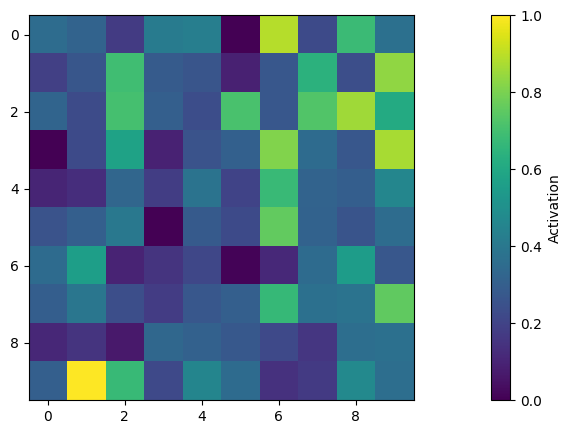

100%|██████████| 200/200 [00:05<00:00, 35.19it/s]


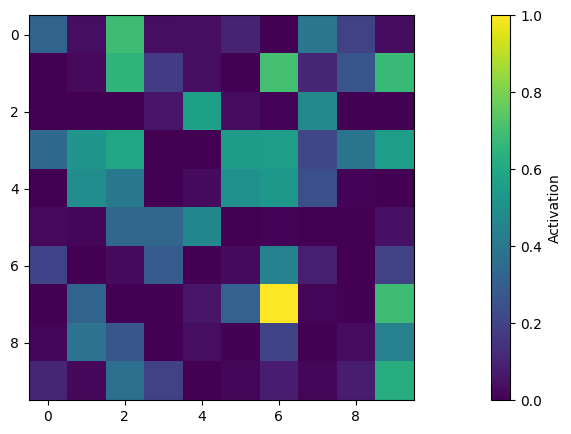

100%|██████████| 200/200 [00:05<00:00, 36.99it/s]


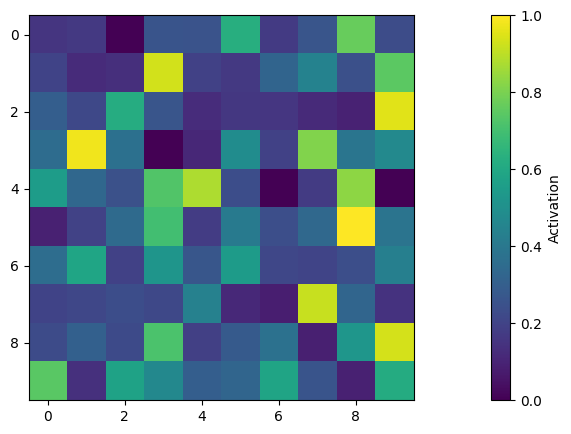

100%|██████████| 200/200 [00:05<00:00, 36.44it/s]


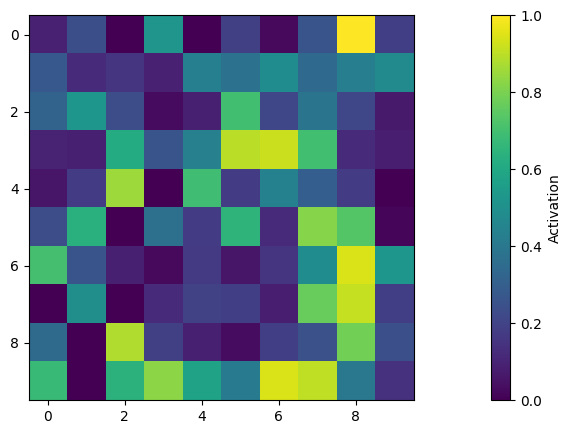

100%|██████████| 200/200 [00:05<00:00, 36.34it/s]


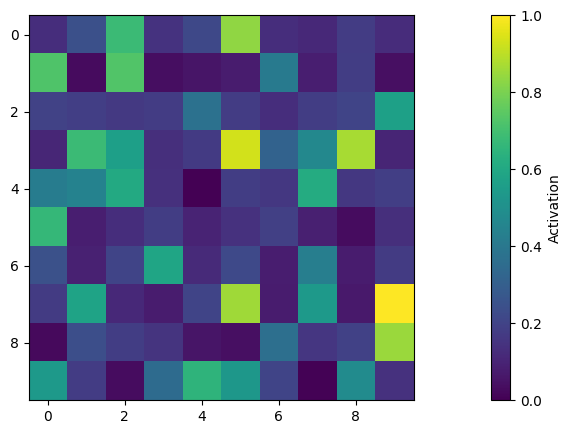

 90%|█████████ | 180/200 [15:14<00:00, 34.07it/s] 

In [597]:
from tqdm import tqdm
for _ in range(10):
    grid_size = 10
    environment = Environment(grid_size=grid_size, render_on=False)
    agent = TransformerAgent(grid_size=grid_size, epsilon=1, epsilon_decay=0.998, epsilon_end=0.01)
    experience_replay = ExperienceReplay(capacity=10000, batch_size=32)
    # Number of episodes to run before training stops
    episodes = 1000
    # Max number of steps in each episode
    max_steps = 200

    for episode in range(episodes):

        # Get the initial state of the environment and set done to False
        state = environment.reset()

        # Loop until the episode finishes
        for step in tqdm(range(max_steps)):
            # print('Episode:', episode)
            # print('Step:', step)
            # print('Epsilon:', agent.epsilon)

            # Get the action choice from the agents policy
            action = agent.get_action(state)

            # Take a step in the environment and save the experience
            reward, next_state, done = environment.step(action)
            experience_replay.add_experience(state, action, reward, next_state, done)

            # If the experience replay has enough memory to provide a sample, train the agent
            if experience_replay.can_provide_sample():
                experiences = experience_replay.sample_batch()
                agent.learn(experiences)
        
        if episode == episodes - 1:
            agent.generate_smooth_grad_cam_pp(experiences, target_class=1)
                #print loss
                #print(agent.criterion(agent.forward(torch.FloatTensor(experiences[0].state).unsqueeze(0)), agent.forward(torch.FloatTensor(experiences[0].state).unsqueeze(0))))

            # Set the state to the next_state
            state = next_state
            
            if done:
                break

In [ ]:
activations = np.array(agent.activations)

In [ ]:
#shape of activations
print(activations.shape)

(2, 1, 32, 100)


In [ ]:
activations[0][0]

array([[-2.875332  ,  0.34098017,  0.37023568, ...,  0.31829557,
         0.36134902,  0.36801025],
       [ 0.36458033, -2.5538454 ,  0.4032137 , ...,  0.34927073,
        -2.5714154 ,  0.4005505 ],
       [ 0.38422182,  0.39438015,  0.42703328, ...,  0.36901954,
        -2.4643857 ,  0.41825286],
       ...,
       [ 0.2700408 ,  0.28801748,  0.3295637 , ...,  0.25176013,
         0.31082675,  0.319794  ],
       [-2.6138175 ,  0.37645826,  0.40385622, ...,  0.34525234,
        -2.5746806 ,  0.39637306],
       [ 0.30916685,  0.32371902,  0.35425368, ...,  0.29232025,
         0.34478584,  0.35207298]], dtype=float32)

In [ ]:
average_activations = []

In [ ]:
for layer_activations in activations:
    # Convert to numpy array and calculate mean over the 0th axis (sequence positions)
    average_activations.append(np.mean(np.array(layer_activations), axis=0))


In [ ]:
average_activations = np.array(average_activations)
print(average_activations.shape)

(2, 32, 100)


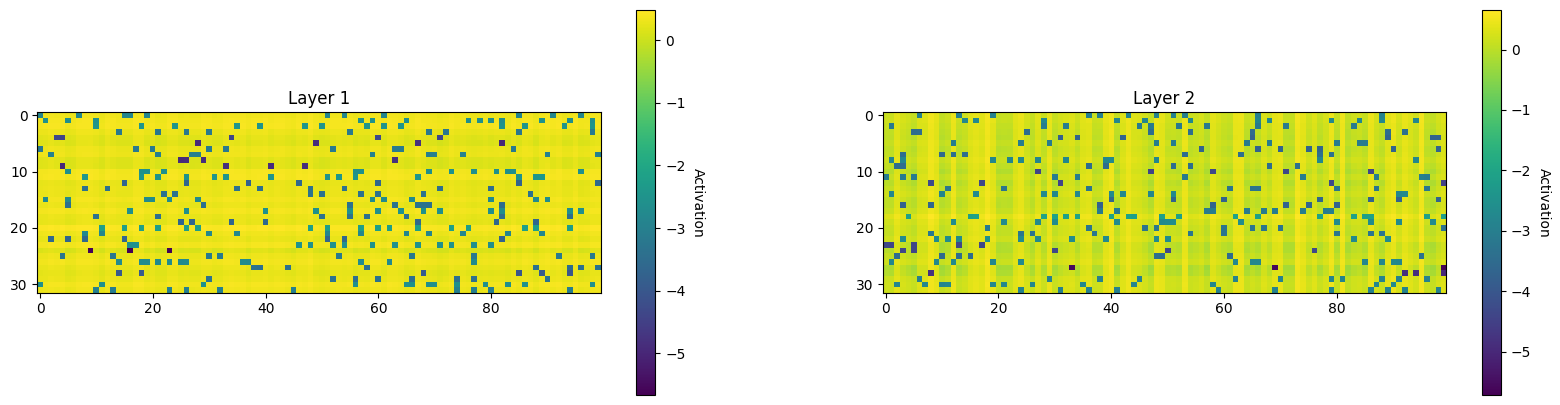

In [ ]:
# Plot the average activations for each layer with heatmap
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(average_activations), figsize=(20, 5))

for i, activations in enumerate(average_activations):
    im = axs[i].imshow(activations, cmap='viridis')
    axs[i].set_title(f'Layer {i+1}')
    
    # Add colorbar to each subplot
    cbar = plt.colorbar(im, ax=axs[i])
    cbar.ax.set_ylabel('Activation', rotation=-90, va="bottom")

plt.show()


